In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
import os
from dotenv import load_dotenv
from pycaret.regression import setup, compare_models ,tune_model, finalize_model,predict_model, save_model,load_model, get_config
import boto3
import joblib
from io import BytesIO, StringIO

In [2]:
load_dotenv()  # <-- musi być tu!

print("ACCESS_KEY:", repr(os.environ.get("ACCESS_KEY")))
print("SECRET_KEY:", repr(os.environ.get("SECRET_KEY")))

session=boto3.session.Session()

client=session.client(
    's3',
    region_name=os.environ.get("REGION_NAME"),
    endpoint_url=os.environ.get("ENPOINT_URL_KEY"),  # zmień na swoje
    aws_access_key_id=os.environ.get("AWS_ACCESS_KEY_ID"),
    aws_secret_access_key=os.environ.get("AWS_SECRET_ACCESS_KEY")
)

try:
    response = client.list_objects_v2(Bucket='maraton.data')  # <- użyj istniejącego bucketa!
    print("✅ Działa! Pliki:")
    for obj in response.get("Contents", []):
        print("-", obj["Key"])
except Exception as e:
    print("❌ Błąd:", e)

ACCESS_KEY: None
SECRET_KEY: None
✅ Działa! Pliki:
- maraton_csv_data/
- maraton_csv_data/data_to_compare.csv
- maraton_csv_data/halfmarathon_wroclaw_2024_final_data.csv
- maraton_model/
- maraton_model/model.pkl


In [3]:
response=client.get_object(
    Bucket="maraton.data",
    Key="maraton_csv_data/halfmarathon_wroclaw_2024_final_data.csv"
)
# maraton_csv_data/halfmarathon_wroclaw_2024_final_data.csv
stream = response["Body"]
body = stream.read()
csv_buffer = BytesIO(body)
df = pd.read_csv(csv_buffer, sep=";")

In [4]:
response = client.get_object(
    Bucket="maraton.data",
    Key="maraton_model/model.pkl"
)

model_buffer = BytesIO(response["Body"].read())   # ⬅️ NIE dekodujemy!
model_buffer.seek(0)

# 3️⃣ Załaduj model (PyCaret to zwykły pickle/joblib)
model = joblib.load(model_buffer)   # lub   model = pickle.load(model_buffer)


In [5]:
# df=pd.read_csv("halfmarathon_wroclaw_2024_final.csv", sep=";")
# df

## 1. Analiza Wstęna

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13007 entries, 0 to 13006
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Miejsce                    10300 non-null  float64
 1   Numer startowy             13007 non-null  int64  
 2   Imię                       13007 non-null  object 
 3   Nazwisko                   13007 non-null  object 
 4   Miasto                     9913 non-null   object 
 5   Kraj                       10300 non-null  object 
 6   Drużyna                    4981 non-null   object 
 7   Płeć                       12998 non-null  object 
 8   Płeć Miejsce               10300 non-null  float64
 9   Kategoria wiekowa          12987 non-null  object 
 10  Kategoria wiekowa Miejsce  10289 non-null  float64
 11  Rocznik                    12723 non-null  float64
 12  5 km Czas                  10288 non-null  object 
 13  5 km Miejsce Open          10288 non-null  flo

In [7]:
df.describe()

,Miejsce,Numer startowy,Płeć Miejsce,Kategoria wiekowa Miejsce,Rocznik,5 km Miejsce Open,5 km Tempo,10 km Miejsce Open,10 km Tempo,15 km Miejsce Open,15 km Tempo,20 km Miejsce Open,20 km Tempo,Tempo Stabilność,Tempo
count,10300.000000,13007.000000,10300.000000,10289.000000,12723.000000,10288.000000,10288.000000,10288.000000,10279.000000,10287.000000,10277.000000,10295.000000,10285.000000,10267.000000,10300.000000
mean,5150.580291,12139.714077,2998.812913,801.826028,1981.801698,5169.467924,5.660503,5160.638802,5.599864,5153.521532,5.953135,5152.556872,6.232792,0.041466,5.889610
std,2973.631580,18040.402435,2052.225956,629.605105,79.316604,2983.060815,0.831907,2978.793840,0.902119,2973.518652,1.020298,2974.758309,1.167877,0.043747,0.960238
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,2.920000,1.000000,3.083333,1.000000,3.086667,-0.127800,3.036265
25%,2575.750000,3466.000000,1288.000000,284.000000,1978.000000,2588.750000,5.089167,2581.750000,4.973333,2579.500000,5.233333,2577.500000,5.406667,0.013000,5.211938
50%,5150.500000,7045.000000,2575.500000,651.000000,1985.000000,5166.500000,5.630000,5158.500000,5.506667,5154.000000,5.820000,5153.000000,6.040000,0.030933,5.771905
75%,7725.250000,10693.500000,4663.250000,1176.000000,1993.000000,7750.250000,6.190000,7739.250000,6.133333,7727.500000,6.563333,7727.500000,6.906667,0.061133,6.481986
max,10302.000000,86990.000000,7240.000000,2388.000000,2006.000000,10353.000000,10.046667,10330.000000,11.346667,10305.000000,11.213333,10306.000000,11.883333,0.436133,10.076637


In [8]:
df.isnull().sum()

Miejsce                      2707
Numer startowy                  0
Imię                            0
Nazwisko                        0
Miasto                       3094
Kraj                         2707
Drużyna                      8026
Płeć                            9
Płeć Miejsce                 2707
Kategoria wiekowa              20
Kategoria wiekowa Miejsce    2718
Rocznik                       284
5 km Czas                    2719
5 km Miejsce Open            2719
5 km Tempo                   2719
10 km Czas                   2719
10 km Miejsce Open           2719
10 km Tempo                  2728
15 km Czas                   2720
15 km Miejsce Open           2720
15 km Tempo                  2730
20 km Czas                   2712
20 km Miejsce Open           2712
20 km Tempo                  2722
Tempo Stabilność             2740
Czas                         2055
Tempo                        2707
dtype: int64

### 1.USUWAMY kolumny z df, które będą nam nie potrzebne podczas tworzenia modelu

In [9]:
df

,Miejsce,Numer startowy,Imię,Nazwisko,Miasto,Kraj,Drużyna,Płeć,Płeć Miejsce,Kategoria wiekowa,...,10 km Tempo,15 km Czas,15 km Miejsce Open,15 km Tempo,20 km Czas,20 km Miejsce Open,20 km Tempo,Tempo Stabilność,Czas,Tempo
0,1.0,596,NIKODEM,DWORCZAK,KOŚCIAN,POL,NaN,M,1.0,M20,...,2.920000,00:45:07,2.0,3.083333,01:00:33,1.0,3.086667,0.007267,01:04:03,3.036265
1,2.0,616,MATEUSZ,KACZOR,RADOM,POL,RLTL OPTIMA RADOM,M,2.0,M20,...,2.920000,00:45:07,3.0,3.083333,01:00:38,2.0,3.103333,0.008267,01:04:24,3.052856
2,3.0,154,PATRYK,KOZŁOWSKI,RADOM,POL,RLTL-ZTE-RADOM,M,3.0,M20,...,2.920000,00:45:07,1.0,3.083333,01:00:59,3.0,3.173333,0.012467,01:04:40,3.065497
3,4.0,591,DARIUSZ,BORATYŃSKI,WROCŁAW,POL,WOSIEK TEAM AZS AWF WROCŁAW,M,4.0,M20,...,3.110000,00:47:48,4.0,3.293333,01:05:40,4.0,3.573333,0.028667,01:09:44,3.305681
4,5.0,521,SZYMON,DOROŻYŃSKI,LUBON,POL,SZYMI TEAM AZS POLITECHNIKA OPOLSKA,M,5.0,M30,...,3.153333,00:48:09,5.0,3.453333,01:06:05,5.0,3.586667,0.039800,01:10:05,3.322272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13002,NaN,6445,ANNA,ŻUROWSKA,NaN,NaN,NaN,K,NaN,K40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DNS,NaN
13003,NaN,23495,JUSTYNA,ŻYGADŁO,NaN,NaN,NaN,K,NaN,K20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13004,NaN,9323,DAWID,ŻYTKOWSKI,NaN,NaN,NaN,M,NaN,M20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DNS,NaN
13005,NaN,27386,DOMINIKA,ĆWIERTNIA,NaN,NaN,NaN,K,NaN,K30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
filtred_df=df.drop(columns=["Miejsce", "Numer startowy","Imię","Płeć Miejsce","Nazwisko","Miasto","Kraj","Drużyna", "Kategoria wiekowa Miejsce","5 km Miejsce Open", "10 km Miejsce Open", "15 km Miejsce Open","20 km Miejsce Open"])
filtred_df.sample(10)

,Płeć,Kategoria wiekowa,Rocznik,5 km Czas,5 km Tempo,10 km Czas,10 km Tempo,15 km Czas,15 km Tempo,20 km Czas,20 km Tempo,Tempo Stabilność,Czas,Tempo
11953,K,K40,1984.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7309,M,M50,1972.0,00:29:49,5.963333,01:02:40,6.570000,01:33:30,6.166667,02:06:41,6.636667,0.032333,02:13:53,6.346686
4649,K,K30,1992.0,00:28:48,5.760000,00:57:09,5.670000,01:25:29,5.666667,01:53:26,5.590000,-0.010267,01:59:38,5.671170
7009,M,M40,1977.0,00:28:17,5.656667,00:57:08,5.770000,01:29:50,6.540000,02:04:42,6.973333,0.094400,02:11:52,6.251086
7869,K,K40,NaN,00:32:40,6.533333,01:04:02,6.273333,01:36:55,6.576667,02:10:00,6.616667,0.011067,02:17:47,6.531564
6425,K,K30,1986.0,00:30:21,6.070000,01:00:11,5.966667,01:31:01,6.166667,02:01:50,6.163333,0.009600,02:08:43,6.101762
1349,M,M40,1975.0,00:24:37,4.923333,00:47:58,4.670000,01:12:04,4.820000,01:36:59,4.983333,0.006600,01:42:35,4.862922
12556,K,K30,1992.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6311,M,M20,1997.0,00:27:55,5.583333,00:56:17,5.673333,01:26:27,6.033333,01:59:42,6.650000,0.071200,02:08:05,6.071739
7689,M,M20,1996.0,00:30:20,6.066667,00:59:17,5.790000,01:30:30,6.243333,02:07:21,7.370000,0.087267,02:16:31,6.471518


### 2. Sprawdzamy null filtred

In [11]:

filtred_df.isnull().sum()

Płeć                    9
Kategoria wiekowa      20
Rocznik               284
5 km Czas            2719
5 km Tempo           2719
10 km Czas           2719
10 km Tempo          2728
15 km Czas           2720
15 km Tempo          2730
20 km Czas           2712
20 km Tempo          2722
Tempo Stabilność     2740
Czas                 2055
Tempo                2707
dtype: int64

In [12]:
filtred_not_null_df=filtred_df[(filtred_df["Czas"].notna()) & (filtred_df["Czas"]!="DNS") & (filtred_df["Czas"]!="DNF") ]
filtred_not_null_df

,Płeć,Kategoria wiekowa,Rocznik,5 km Czas,5 km Tempo,10 km Czas,10 km Tempo,15 km Czas,15 km Tempo,20 km Czas,20 km Tempo,Tempo Stabilność,Czas,Tempo
0,M,M20,1998.0,00:15:06,3.020000,00:29:42,2.920000,00:45:07,3.083333,01:00:33,3.086667,0.007267,01:04:03,3.036265
1,M,M20,1997.0,00:15:06,3.020000,00:29:42,2.920000,00:45:07,3.083333,01:00:38,3.103333,0.008267,01:04:24,3.052856
2,M,M20,1998.0,00:15:06,3.020000,00:29:42,2.920000,00:45:07,3.083333,01:00:59,3.173333,0.012467,01:04:40,3.065497
3,M,M20,1997.0,00:15:47,3.156667,00:31:20,3.110000,00:47:48,3.293333,01:05:40,3.573333,0.028667,01:09:44,3.305681
4,M,M30,1992.0,00:15:07,3.023333,00:30:53,3.153333,00:48:09,3.453333,01:06:05,3.586667,0.039800,01:10:05,3.322272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10295,K,K70,1948.0,00:43:30,8.700000,01:28:06,8.920000,NaN,NaN,NaN,NaN,NaN,03:19:47,9.470649
10296,K,K40,1978.0,00:42:06,8.420000,01:27:34,9.093333,02:15:28,9.580000,03:10:19,10.970000,0.162733,03:21:08,9.534645
10297,K,K60,1955.0,00:49:20,9.866667,01:38:19,9.796667,02:23:22,9.010000,03:11:34,9.640000,-0.029333,03:22:18,9.589950
10298,K,K40,1981.0,00:46:48,9.360000,01:36:09,9.870000,02:26:03,9.980000,03:17:25,10.273333,0.057000,03:28:32,9.885439


### Operacje prowadzące do sformatowania danych i oczyszczenia z nieprawidłowych

In [13]:
def time_to_minutes(time_str):
    """Konwertuje czas w formacie HH:MM:SS na liczbę sekund (float)."""
    h, m, s = map(int, time_str.split(":"))
    return h * 3600 + m*60 + s

In [14]:
filtred_not_null_df["Czas"]=filtred_not_null_df["Czas"].apply(time_to_minutes)

In [15]:
(filtred_not_null_df["Czas"]=="NFD").sum()

0

In [16]:
filtred_df_check=((filtred_not_null_df["Czas"]< 4_000 )| (filtred_not_null_df["Czas"]> 10_400) ).sum()
filtred_df_check

183

In [17]:
filtred_not_null_df[filtred_not_null_df["5 km Tempo"]==0]
checking=filtred_df[
    ["5 km Czas", "5 km Tempo", "10 km Czas", "10 km Tempo", 
     "15 km Czas", "15 km Tempo", "20 km Czas", "20 km Tempo", ]
].notna().all(axis=1)

In [18]:
checking_df=filtred_df[checking]
checking_df

,Płeć,Kategoria wiekowa,Rocznik,5 km Czas,5 km Tempo,10 km Czas,10 km Tempo,15 km Czas,15 km Tempo,20 km Czas,20 km Tempo,Tempo Stabilność,Czas,Tempo
0,M,M20,1998.0,00:15:06,3.020000,00:29:42,2.920000,00:45:07,3.083333,01:00:33,3.086667,0.007267,01:04:03,3.036265
1,M,M20,1997.0,00:15:06,3.020000,00:29:42,2.920000,00:45:07,3.083333,01:00:38,3.103333,0.008267,01:04:24,3.052856
2,M,M20,1998.0,00:15:06,3.020000,00:29:42,2.920000,00:45:07,3.083333,01:00:59,3.173333,0.012467,01:04:40,3.065497
3,M,M20,1997.0,00:15:47,3.156667,00:31:20,3.110000,00:47:48,3.293333,01:05:40,3.573333,0.028667,01:09:44,3.305681
4,M,M30,1992.0,00:15:07,3.023333,00:30:53,3.153333,00:48:09,3.453333,01:06:05,3.586667,0.039800,01:10:05,3.322272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10294,K,K40,1977.0,00:39:56,7.986667,01:24:16,8.866667,02:10:58,9.340000,03:04:58,10.800000,0.178267,03:17:46,9.375049
10296,K,K40,1978.0,00:42:06,8.420000,01:27:34,9.093333,02:15:28,9.580000,03:10:19,10.970000,0.162733,03:21:08,9.534645
10297,K,K60,1955.0,00:49:20,9.866667,01:38:19,9.796667,02:23:22,9.010000,03:11:34,9.640000,-0.029333,03:22:18,9.589950
10298,K,K40,1981.0,00:46:48,9.360000,01:36:09,9.870000,02:26:03,9.980000,03:17:25,10.273333,0.057000,03:28:32,9.885439


In [19]:
filtred_df.count()

Płeć                 12998
Kategoria wiekowa    12987
Rocznik              12723
5 km Czas            10288
5 km Tempo           10288
10 km Czas           10288
10 km Tempo          10279
15 km Czas           10287
15 km Tempo          10277
20 km Czas           10295
20 km Tempo          10285
Tempo Stabilność     10267
Czas                 10952
Tempo                10300
dtype: int64

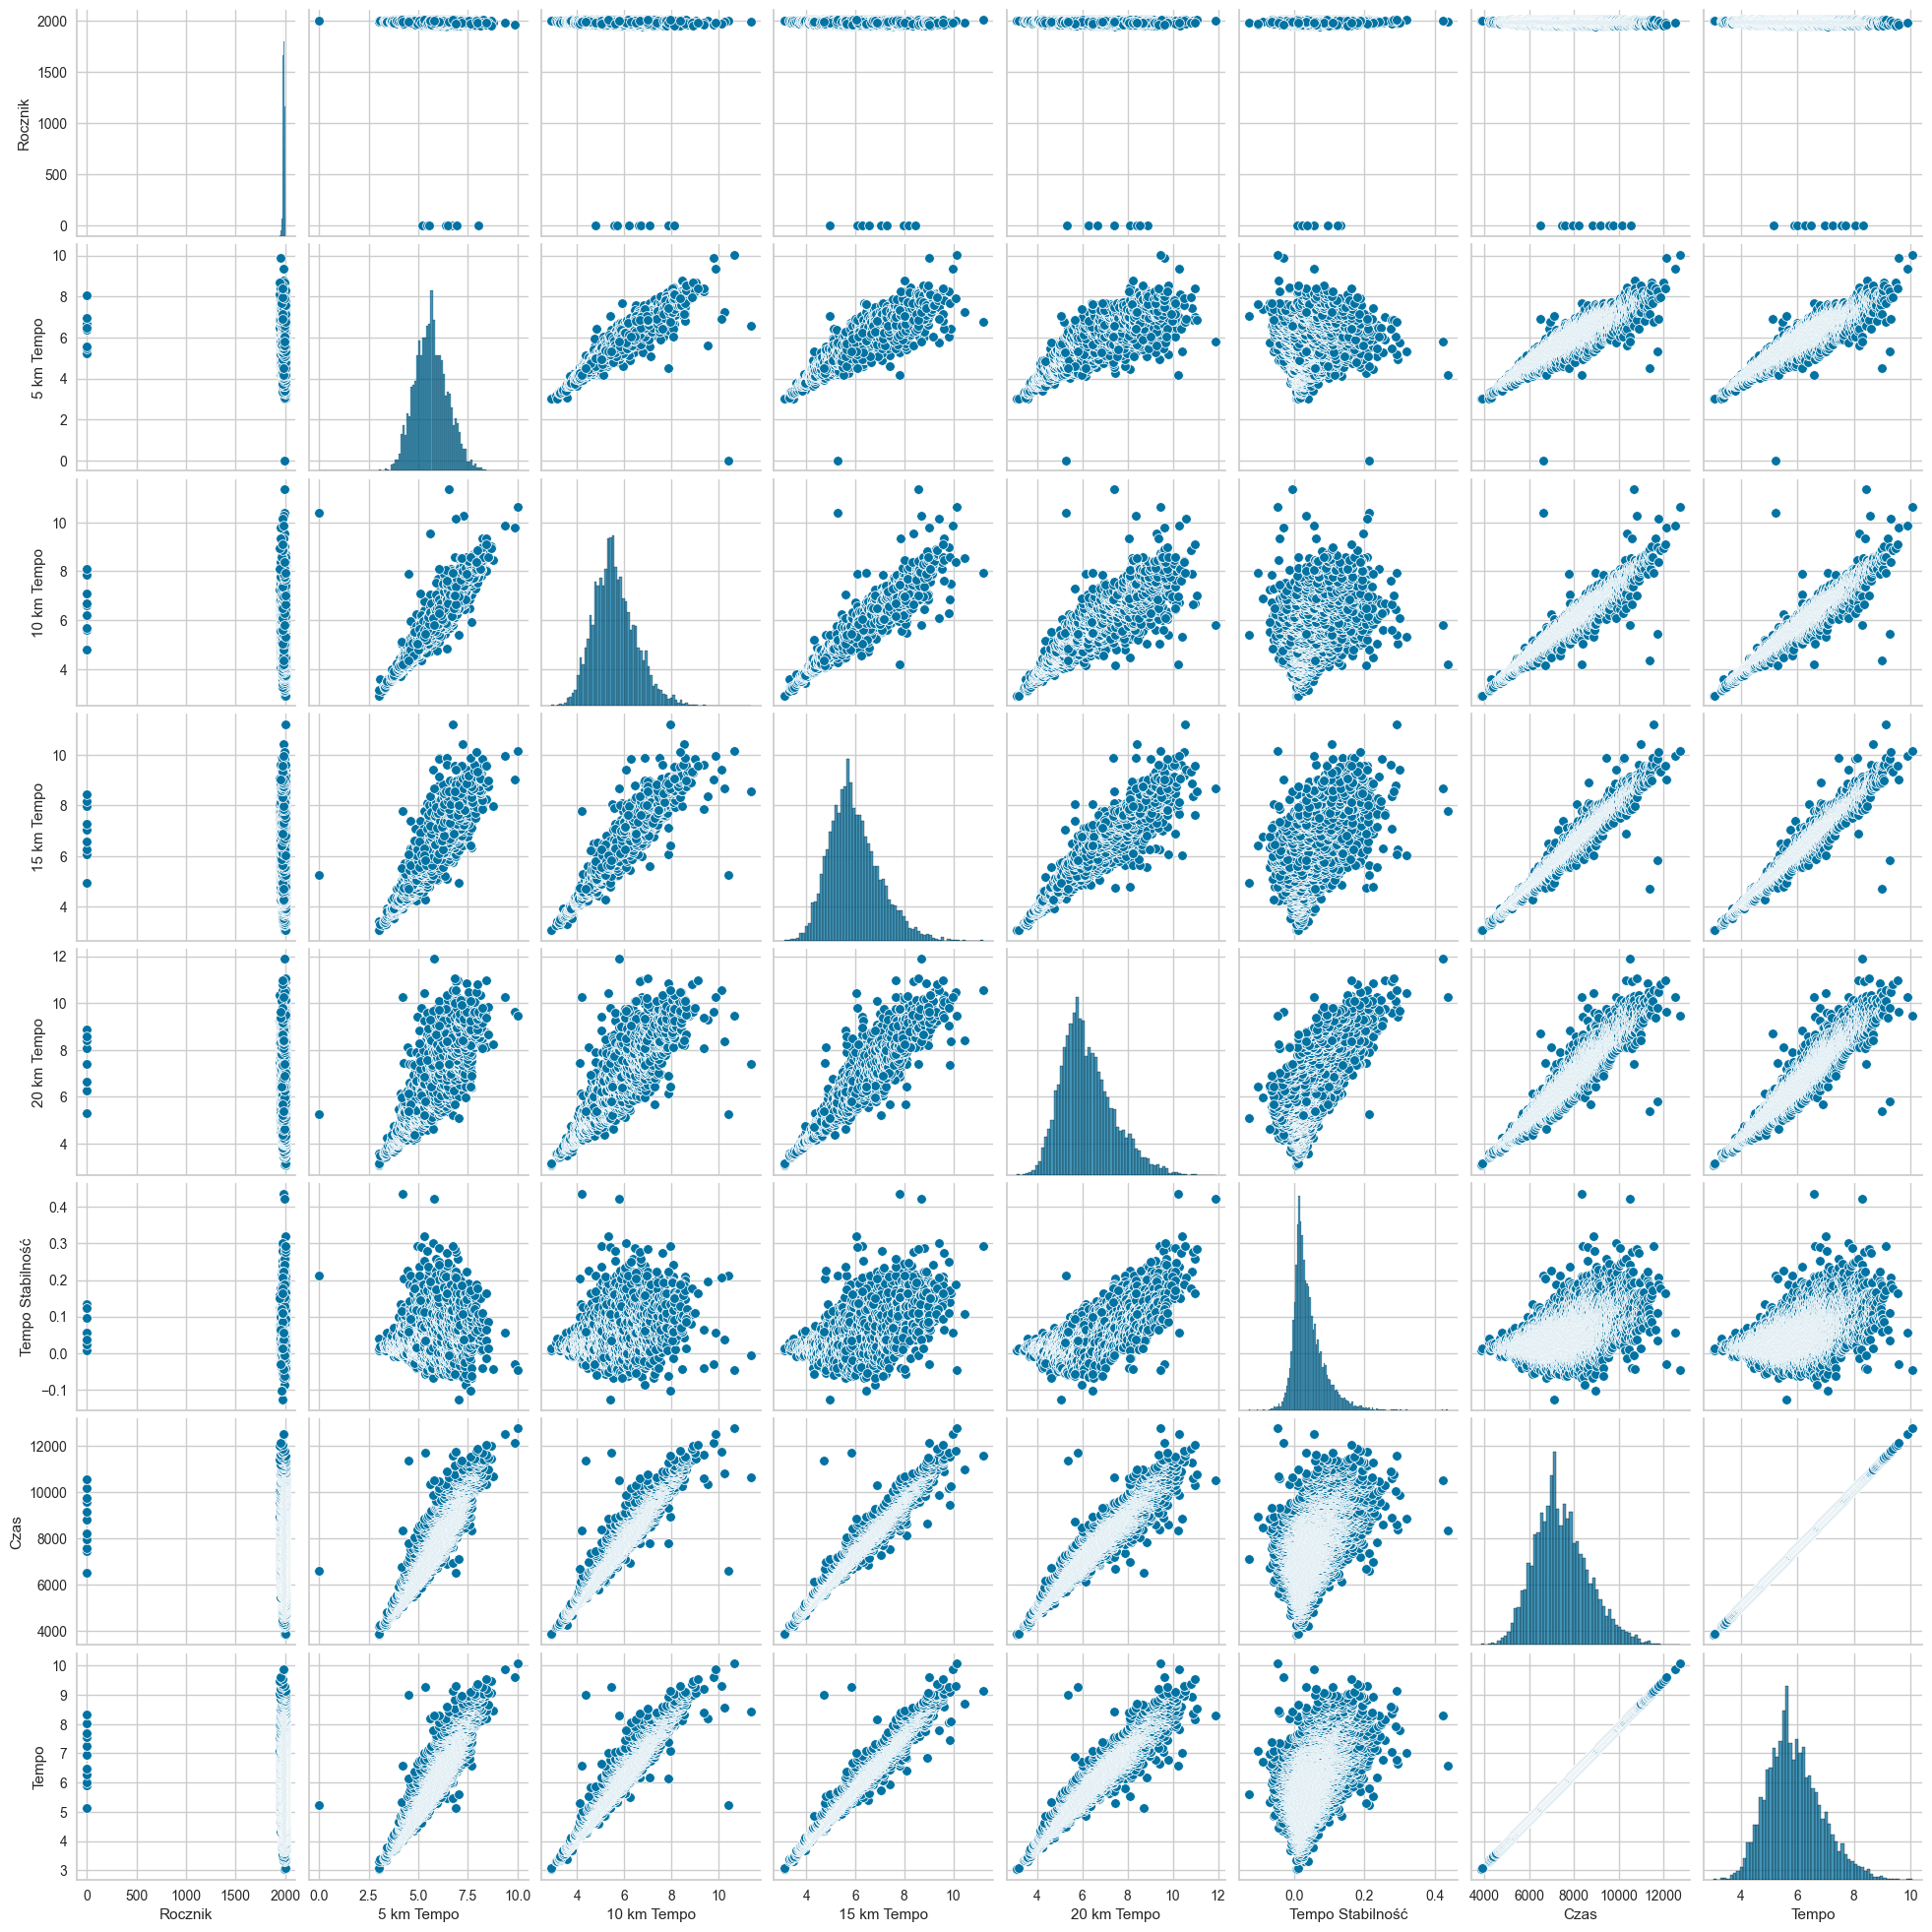

In [20]:
sns.pairplot(data=filtred_not_null_df)


<Axes: xlabel='Rocznik'>

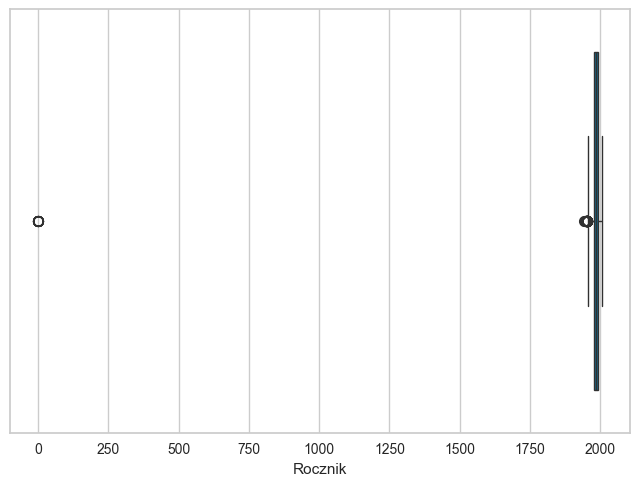

In [21]:
sns.boxplot(x="Rocznik", data=filtred_not_null_df)


## Sprawdzanie wartości odstających i ususwanie outliersów

In [22]:
checking_convert_df=checking_df.copy()
checking_convert_df["5 km Czas"]=checking_df["5 km Czas"].apply(time_to_minutes)
checking_convert_df["10 km Czas"]=checking_df["10 km Czas"].apply(time_to_minutes)
checking_convert_df["Czas"]=checking_df["Czas"].apply(time_to_minutes)

<Axes: xlabel='Czas'>

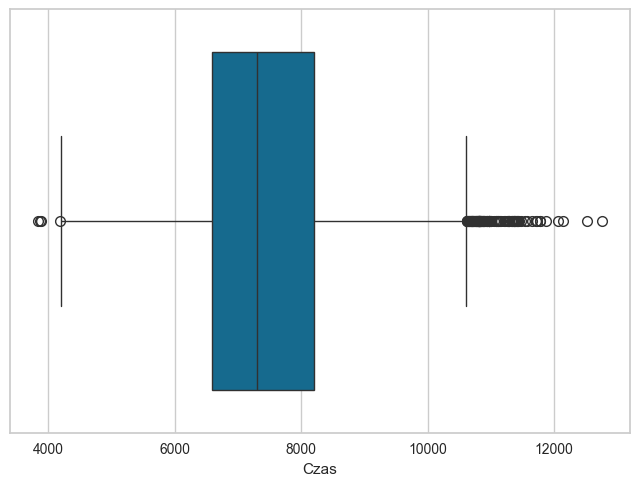

In [23]:
sns.boxplot(x="Czas", data=checking_convert_df)


In [24]:
checking_convert_df.tail()

,Płeć,Kategoria wiekowa,Rocznik,5 km Czas,5 km Tempo,10 km Czas,10 km Tempo,15 km Czas,15 km Tempo,20 km Czas,20 km Tempo,Tempo Stabilność,Czas,Tempo
10294,K,K40,1977.0,2396,7.986667,5056,8.866667,02:10:58,9.340000,03:04:58,10.800000,0.178267,11866,9.375049
10296,K,K40,1978.0,2526,8.420000,5254,9.093333,02:15:28,9.580000,03:10:19,10.970000,0.162733,12068,9.534645
10297,K,K60,1955.0,2960,9.866667,5899,9.796667,02:23:22,9.010000,03:11:34,9.640000,-0.029333,12138,9.589950
10298,K,K40,1981.0,2808,9.360000,5769,9.870000,02:26:03,9.980000,03:17:25,10.273333,0.057000,12512,9.885439
10299,M,M40,NaN,3014,10.046667,6208,10.646667,02:34:09,10.136667,03:21:22,9.443333,-0.046400,12754,10.076637


In [25]:
df_odst_not= checking_convert_df[(checking_convert_df["Czas"]>4250) & (checking_convert_df["Czas"]<10200) ]
df_odst_not

,Płeć,Kategoria wiekowa,Rocznik,5 km Czas,5 km Tempo,10 km Czas,10 km Tempo,15 km Czas,15 km Tempo,20 km Czas,20 km Tempo,Tempo Stabilność,Czas,Tempo
7,M,M20,1996.0,923,3.076667,1996,3.576667,00:49:47,3.303333,01:07:13,3.486667,0.019133,4277,3.379158
8,M,M20,1995.0,997,3.323333,1977,3.266667,00:49:54,3.390000,01:07:34,3.533333,0.015067,4284,3.384688
9,M,M30,1988.0,1002,3.340000,1977,3.250000,00:49:54,3.390000,01:07:34,3.533333,0.014400,4284,3.384688
10,M,M20,2001.0,976,3.253333,1965,3.296667,00:49:47,3.406667,01:07:44,3.590000,0.022400,4309,3.404440
11,M,M30,1994.0,996,3.320000,1966,3.233333,00:49:50,3.413333,01:07:45,3.583333,0.019400,4312,3.406810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10046,M,M30,1990.0,2339,7.796667,4661,7.740000,01:58:14,8.110000,02:40:27,8.443333,0.046200,10187,8.048511
10047,K,K40,1983.0,2216,7.386667,4526,7.700000,01:56:21,8.183333,02:39:53,8.706667,0.088867,10192,8.052461
10048,K,K40,1983.0,2216,7.386667,4526,7.700000,01:56:21,8.183333,02:39:52,8.703333,0.088667,10192,8.052461
10049,M,M40,1983.0,2219,7.396667,4525,7.686667,01:56:15,8.166667,02:39:53,8.726667,0.089400,10194,8.054041


<Axes: xlabel='Czas'>

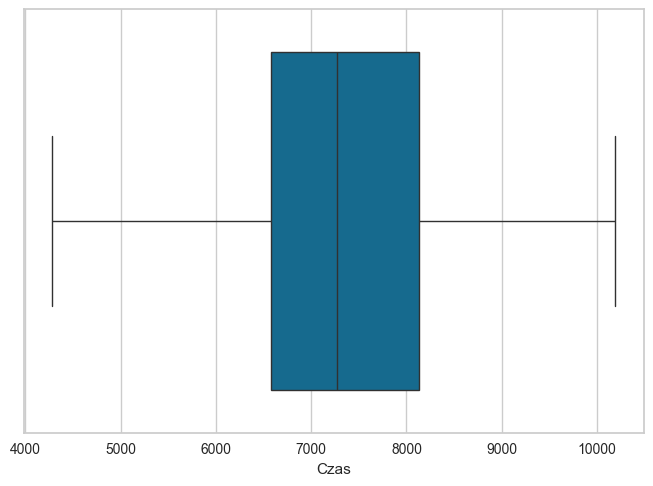

In [26]:
sns.boxplot(x="Czas", data=df_odst_not)


<Axes: xlabel='Czas'>

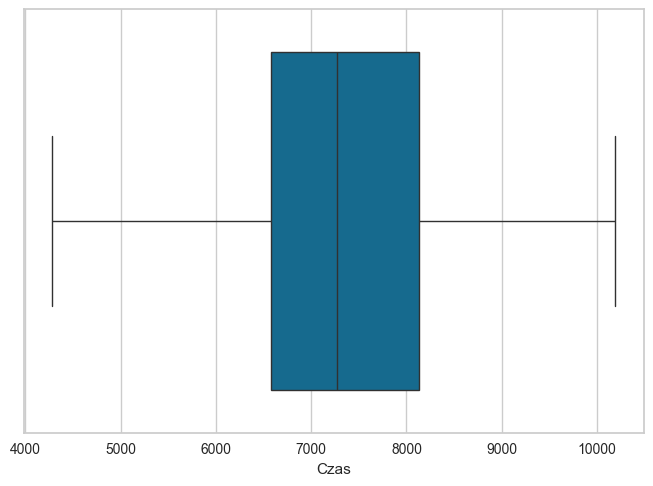

In [27]:
sns.boxplot(x="Czas", data=df_odst_not)


<Axes: xlabel='10 km Czas'>

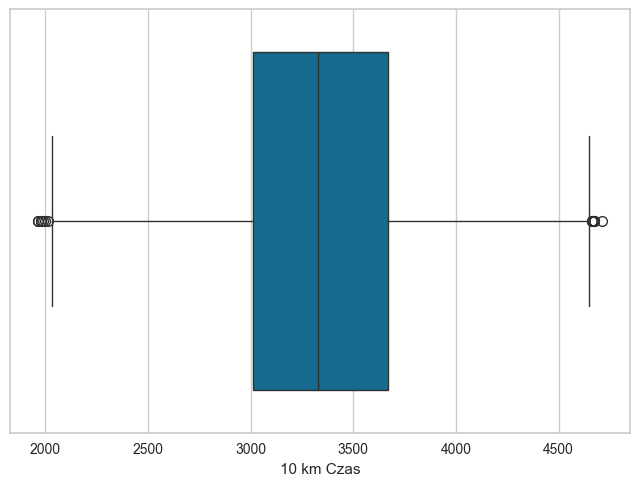

In [28]:
sns.boxplot(x="10 km Czas", data=df_odst_not)


In [29]:
tempo_war=(df_odst_not["5 km Tempo"]>3.45) & (df_odst_not["5 km Tempo"]<7.75) & (df_odst_not["10 km Tempo"]<7.80)


In [30]:
df_ost_first=df_odst_not[tempo_war]

<Axes: xlabel='Czas'>

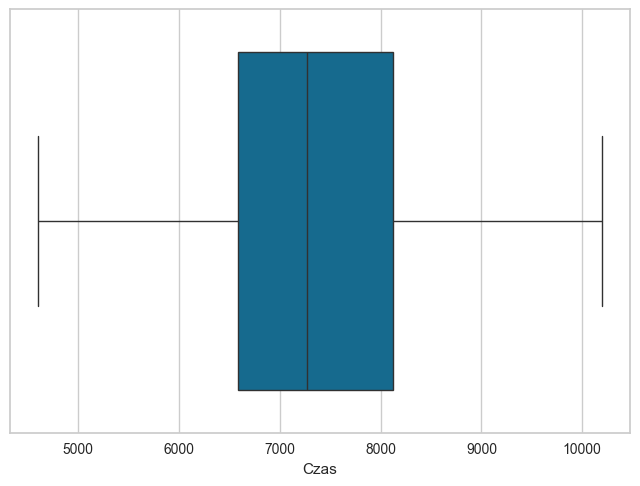

In [31]:
sns.boxplot(x=df_ost_first["Czas"])

<Axes: xlabel='5 km Czas'>

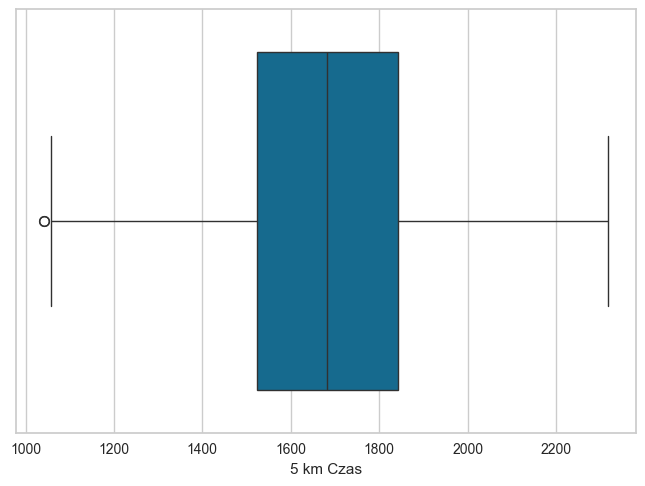

In [32]:
sns.boxplot(x=df_ost_first["5 km Czas"])

<Axes: xlabel='10 km Czas'>

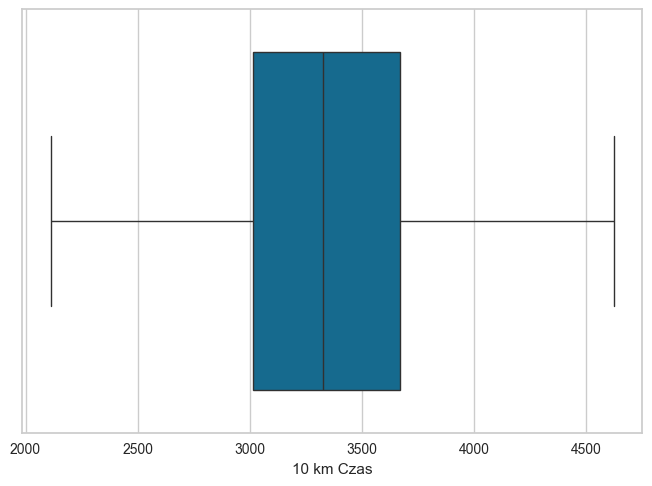

In [33]:
sns.boxplot(x=df_ost_first["10 km Czas"])

<Axes: xlabel='5 km Tempo'>

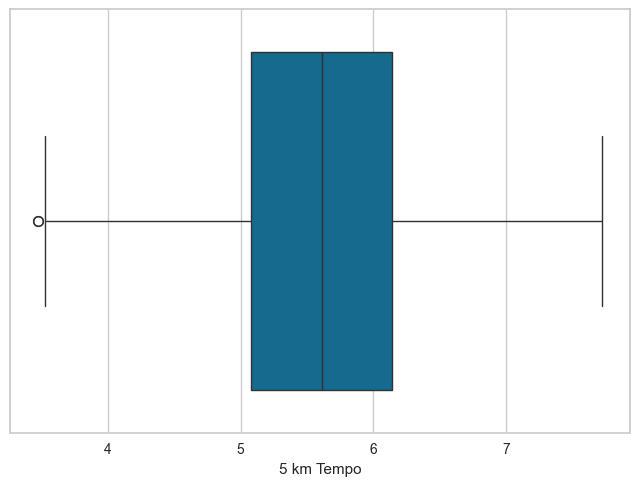

In [34]:
sns.boxplot(x=df_ost_first["5 km Tempo"])

<Axes: xlabel='10 km Tempo'>

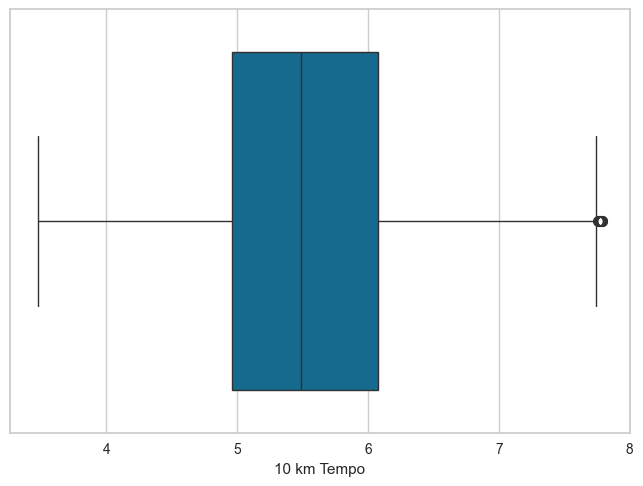

In [35]:
sns.boxplot(x=df_ost_first["10 km Tempo"])

In [36]:
df_new=df_odst_not[df_odst_not["Rocznik"].isna()]
df_new

,Płeć,Kategoria wiekowa,Rocznik,5 km Czas,5 km Tempo,10 km Czas,10 km Tempo,15 km Czas,15 km Tempo,20 km Czas,20 km Tempo,Tempo Stabilność,Czas,Tempo
38,M,M30,NaN,1100,3.666667,2191,3.636667,00:55:34,3.810000,01:14:55,3.870000,0.015667,4766,3.765505
104,M,M30,NaN,1175,3.916667,2329,3.846667,00:58:54,4.016667,01:19:47,4.176667,0.019000,5067,4.003318
208,M,M30,NaN,1201,4.003333,2391,3.966667,01:00:42,4.170000,01:22:55,4.443333,0.030467,5307,4.192937
298,M,M30,NaN,1269,4.230000,2501,4.106667,01:02:59,4.260000,01:25:08,4.430000,0.015067,5415,4.278265
786,M,M20,NaN,1464,4.880000,2826,4.540000,01:10:11,4.616667,01:32:51,4.533333,-0.019267,5858,4.628269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9988,M,M50,NaN,2115,7.050000,4335,7.400000,01:53:42,8.290000,02:37:24,8.740000,0.119200,10058,7.946591
10021,K,K30,NaN,2081,6.936667,4195,7.046667,01:50:20,8.083333,02:37:41,9.470000,0.172733,10112,7.989255
10024,K,K40,NaN,2116,7.053333,4365,7.496667,01:55:18,8.510000,02:39:20,8.806667,0.125467,10118,7.993995
10032,M,M30,NaN,2125,7.083333,4300,7.250000,01:52:52,8.240000,02:37:46,8.980000,0.133600,10149,8.018488


In [37]:
df_ost_first["Kategoria wiekowa"].value_counts()

Kategoria wiekowa
M40    2351
M30    2281
M20    1340
K30    1008
K40     976
M50     805
K20     653
M60     248
K50     217
K60      41
M70      37
K70       4
M80       1
Name: count, dtype: int64

In [38]:
df_final=df_ost_first[["Płeć","Kategoria wiekowa", "5 km Czas", "10 km Czas","Czas", "Tempo"]]
df_final

,Płeć,Kategoria wiekowa,5 km Czas,10 km Czas,Czas,Tempo
18,M,M40,1088,2145,4604,3.637513
19,M,M30,1073,2117,4608,3.640673
20,K,K20,1057,2112,4616,3.646994
21,K,K30,1042,2112,4625,3.654104
22,M,M20,1101,2167,4645,3.669906
...,...,...,...,...,...,...
10045,K,K20,2268,4534,10186,8.047721
10047,K,K40,2216,4526,10192,8.052461
10048,K,K40,2216,4526,10192,8.052461
10049,M,M40,2219,4525,10194,8.054041


In [39]:
df_final["Kategoria wiekowa"].value_counts()

Kategoria wiekowa
M40    2351
M30    2281
M20    1340
K30    1008
K40     976
M50     805
K20     653
M60     248
K50     217
K60      41
M70      37
K70       4
M80       1
Name: count, dtype: int64

In [40]:
# df_final=df_ost_first["Płeć", "5 km Czas", "10 km Czas","Czas", "Tempo"]
# df_final

In [41]:
df_final["Tempo"].astype

<bound method NDFrame.astype of 18       3.637513
19       3.640673
20       3.646994
21       3.654104
22       3.669906
           ...   
10045    8.047721
10047    8.052461
10048    8.052461
10049    8.054041
10050    8.054041
Name: Tempo, Length: 9969, dtype: float64>

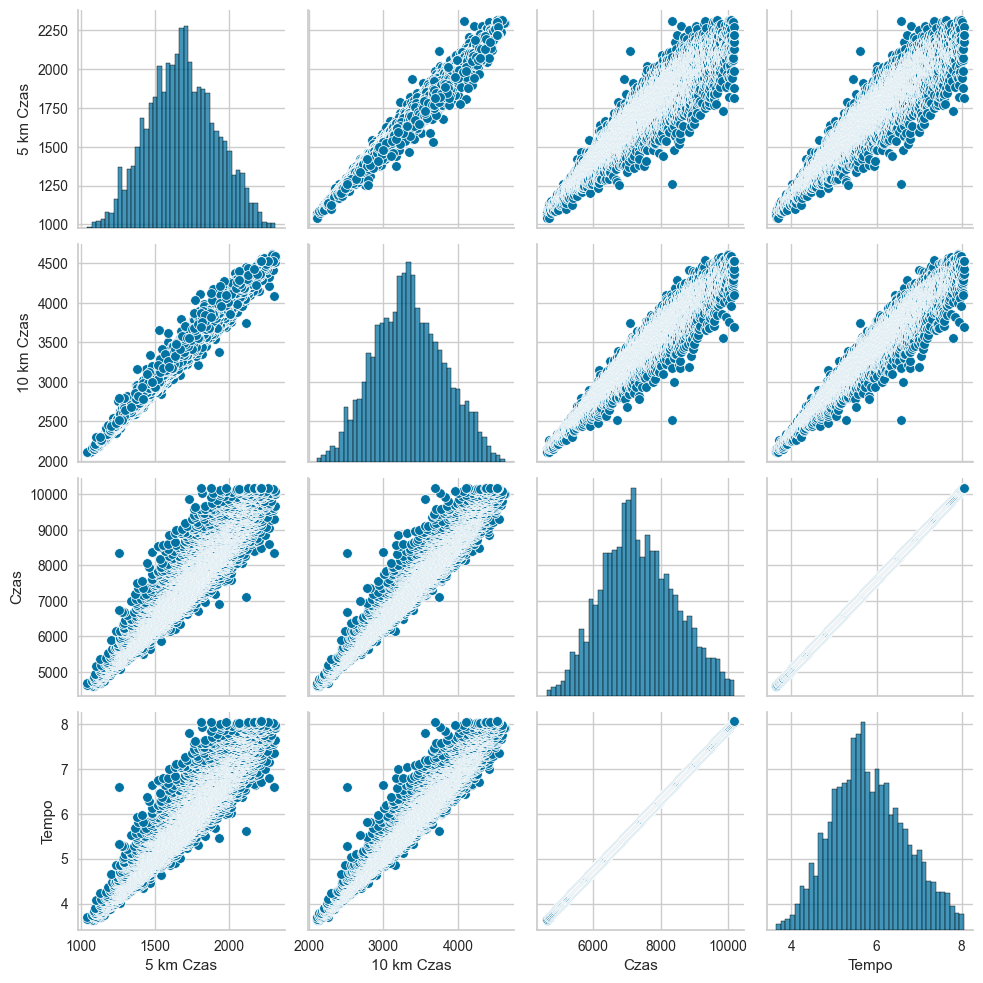

In [42]:
sns.pairplot(data=df_final)

In [43]:
df_final.rename(columns={
    "Płeć":"sex",
    "Kategoria wiekowa":"sex_cat",
    "5 km Czas":"time_5km",
    "10 km Czas":"time_10km",
    "5 km Tempo":"speed_5km",
    "10 km Tempo":"speed_10km",
    "Tempo":"tempo",
    "Czas":"time"
}, inplace=True)

In [44]:
df_final[(df_final["time_10km"]>2400) & (df_final["time_10km"]<2600) & (df_final["time"]>8200) & (df_final["time"]<8400) ]

,sex,sex_cat,time_5km,time_10km,time,tempo
8022,M,M30,1257,2511,8336,6.586079


In [45]:
df_final[(df_final["time_5km"]>2100) & (df_final["time_5km"]<2400) & (df_final["time"]>7000) & (df_final["time"]<7500) ]


,sex,sex_cat,time_5km,time_10km,time,tempo
4293,M,M40,2115,3738,7095,5.605594


In [46]:
df_final.drop(8022, inplace=True)


In [47]:
df_final.drop(4293, inplace=True)

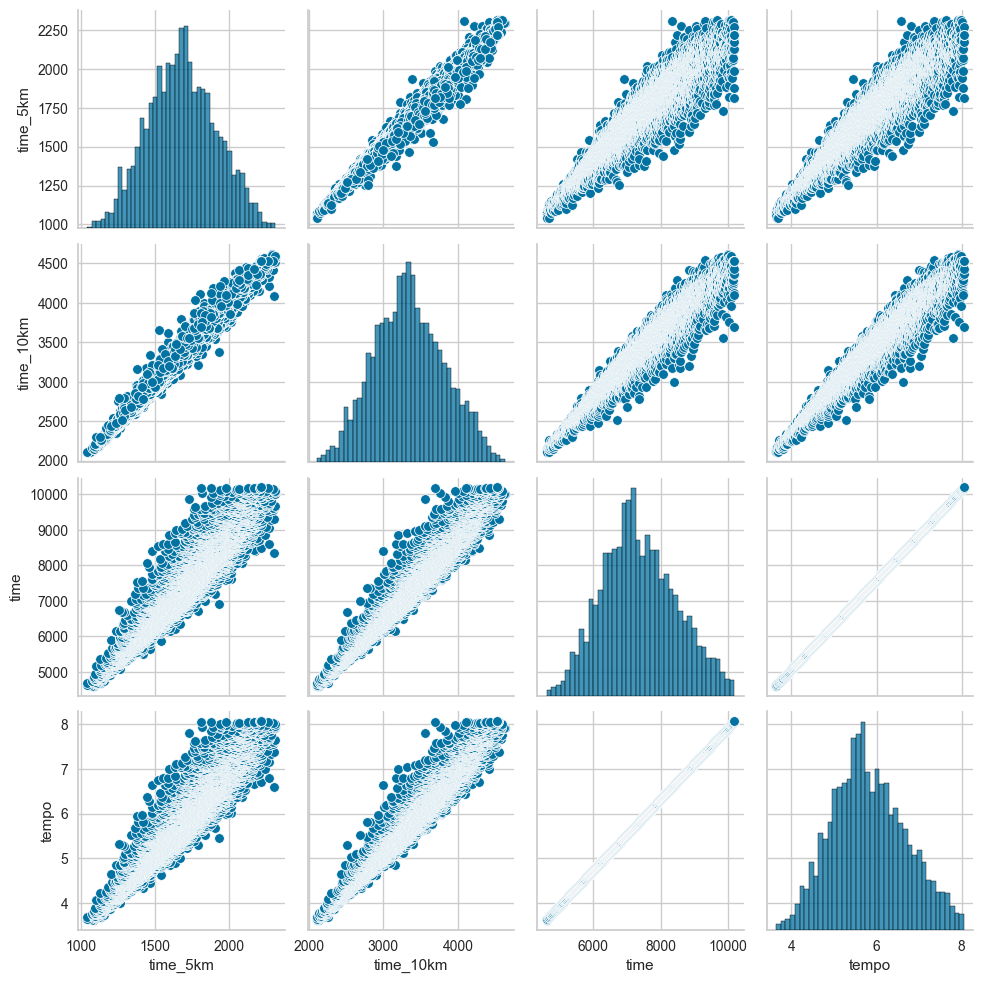

In [48]:
sns.pairplot(data=df_final)

In [49]:
df_final

,sex,sex_cat,time_5km,time_10km,time,tempo
18,M,M40,1088,2145,4604,3.637513
19,M,M30,1073,2117,4608,3.640673
20,K,K20,1057,2112,4616,3.646994
21,K,K30,1042,2112,4625,3.654104
22,M,M20,1101,2167,4645,3.669906
...,...,...,...,...,...,...
10045,K,K20,2268,4534,10186,8.047721
10047,K,K40,2216,4526,10192,8.052461
10048,K,K40,2216,4526,10192,8.052461
10049,M,M40,2219,4525,10194,8.054041


In [50]:
df_final["sex_cat"].value_counts()

sex_cat
M40    2350
M30    2280
M20    1340
K30    1008
K40     976
M50     805
K20     653
M60     248
K50     217
K60      41
M70      37
K70       4
M80       1
Name: count, dtype: int64

In [51]:
def sex_to_cat(sex):
    return 1 if sex=="M" else 0

In [52]:
def year_cat_to_number(year_cat):
    match year_cat:
        case "M20":
            return 1
        case "M30":
            return 2
        case "M40":
            return 3
        case "M50":
            return 4
        case "M60":
            return 5
        case "M70":
            return 6
        case "M80":
            return 7
        case "K20":
            return 8
        case "K30":
            return 9
        case "K40":
            return 10
        case "K50":
            return 11
        
        
        

In [53]:
df_final["sex"]=df_final["sex"].apply(sex_to_cat)

In [54]:
df_final.sample(10)

,sex,sex_cat,time_5km,time_10km,time,tempo
1405,1,M40,1501,2878,6182,4.884254
3285,1,M50,1593,3140,6839,5.403334
3584,1,M20,1711,3321,6921,5.468120
7966,1,M20,1804,3596,8310,6.565537
5903,1,M40,1795,3508,7558,5.971399
821,1,M40,1363,2695,5875,4.641700
2554,0,K40,1564,3086,6591,5.207395
3255,1,M20,1767,3374,6828,5.394643
2468,0,K50,1591,3088,6570,5.190804
7799,1,M30,1931,3816,8236,6.507071


In [55]:
df_final["tempo"]=df_final["tempo"].round(2)

In [56]:
df_final["sex"]==1

18        True
19        True
20       False
21       False
22        True
         ...  
10045    False
10047    False
10048    False
10049     True
10050     True
Name: sex, Length: 9967, dtype: bool

In [57]:
df_to_model=df_final[["sex","time_5km","time_10km","time"]]

In [58]:
df_to_model

,sex,time_5km,time_10km,time
18,1,1088,2145,4604
19,1,1073,2117,4608
20,0,1057,2112,4616
21,0,1042,2112,4625
22,1,1101,2167,4645
...,...,...,...,...
10045,0,2268,4534,10186
10047,0,2216,4526,10192
10048,0,2216,4526,10192
10049,1,2219,4525,10194


In [ ]:
setup(data=df_to_model, session_id=123, categorical_features=["sex"], target="time")

In [ ]:
best_model=compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,288.3184,149525.8399,386.1540,0.8770,0.0498,0.0380,0.0350
lasso,Lasso Regression,288.3643,149574.9657,386.2369,0.8770,0.0497,0.0380,0.0310
ridge,Ridge Regression,288.3067,149521.9628,386.1492,0.8770,0.0497,0.0380,0.0340
llar,Lasso Least Angle Regression,288.3643,149574.9639,386.2369,0.8770,0.0497,0.0380,0.0340
en,Elastic Net,288.3126,149610.2045,386.2902,0.8769,0.0497,0.0380,0.0380
omp,Orthogonal Matching Pursuit,288.3177,149635.8571,386.3254,0.8769,0.0497,0.0380,0.0330
br,Bayesian Ridge,288.4076,149656.1519,386.3458,0.8769,0.0498,0.0380,0.0330
gbr,Gradient Boosting Regressor,288.7098,149910.7033,386.6818,0.8767,0.0498,0.0381,0.1220
huber,Huber Regressor,284.3837,152643.3746,390.0705,0.8745,0.0500,0.0372,0.0410
lightgbm,Light Gradient Boosting Machine,292.9580,154047.2355,392.0154,0.8733,0.0505,0.0386,0.2030


In [ ]:
best_model=tune_model(best_model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,285.4996,144273.7622,379.8339,0.8751,0.0493,0.0380
1,297.3634,164510.8841,405.5994,0.8770,0.0516,0.0387
2,275.6758,132714.9466,364.3006,0.8952,0.0472,0.0367
3,298.3520,155422.9596,394.2372,0.8620,0.0508,0.0394
4,322.8369,183058.5046,427.8534,0.8589,0.0543,0.0416
5,278.6769,147385.4360,383.9081,0.8745,0.0491,0.0366
6,284.9228,148849.2351,385.8098,0.8791,0.0499,0.0377
7,298.2713,158122.8092,397.6466,0.8685,0.0514,0.0391
8,266.8574,127922.9677,357.6632,0.8987,0.0466,0.0355


Fitting 10 folds for each of 2 candidates, totalling 20 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [ ]:
best_model=finalize_model(best_model)

In [ ]:
save_model(best_model, "marathon_pipeline")

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['time_5km', 'time_10km'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=['sex'],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('ordinal_encoding',
                  TransformerWrapper(include=['sex'],
                                     transformer=OrdinalEncoder(cols=['sex'],
                                                                handle_missing='return_nan',
                                                                mapping=[{'col': 'sex',
                                                                          'data_type': dtype('float64'),
                                                                          'mapping': 0.0    0
 1.0    1
 NaN   -1
 dtype: int64}]))),
    

In [ ]:
df_test=pd.DataFrame([{'sex': 1,
 'time_5km': 1690,
 "time_10km":3368}])

In [ ]:
model=load_model("marathon_pipeline")

Transformation Pipeline and Model Successfully Loaded


In [ ]:
b=predict_model(model, data=df_test)

In [ ]:
a=predict_model(best_model, data=df_test)

In [ ]:
a["sex"]

0    1
Name: sex, dtype: int8

In [ ]:
df_final.to_csv("marathon_data.csv", sep=";")

In [ ]:
df=pd.read_csv("marathon_data.csv", sep=";")

In [ ]:
df["time_10km"].min()

2112

In [ ]:
load_dotenv()  # <-- musi być tu!

print("ACCESS_KEY:", repr(os.environ.get("ACCESS_KEY")))
print("SECRET_KEY:", repr(os.environ.get("SECRET_KEY")))
print("Bucket:", os.environ.get("BUCKET"))

session=boto3.session.Session()

client=session.client(
    's3',
    region_name=os.environ.get("REGION_NAME"),
    endpoint_url=os.environ.get("ENPOINT_URL_KEY"),  # zmień na swoje
    aws_access_key_id=os.environ.get("AWS_ACCESS_KEY_ID"),
    aws_secret_access_key=os.environ.get("AWS_SECRET_ACCESS_KEY")
)

with open("marathon_data.csv", "rb") as csv_file:
    client.put_object(
        Bucket="maraton.data",
        Key="maraton_csv_data/data_to_compare.csv",               # np. data/dane.csv
        Body=csv_file,
        ContentType="text/csv"
    )

# 📤 Wysyłka pipeline'u
with open("marathon_pipeline.pkl", "rb") as model_file:
    client.put_object(
        Bucket="maraton.data",
        Key="maraton_model/model.pkl",           # np. models/pipeline.pkl
        Body=model_file,
        ContentType="application/octet-stream"
    )

ACCESS_KEY: 'twoj_klucz'
SECRET_KEY: 'twoj_sekret'
Bucket: my-bucket


In [ ]:
df

,Unnamed: 0,sex,sex_year_cat,time_5km,time_10km,time,tempo
0,18,1,M40,1088,2145,4604,3.64
1,19,1,M30,1073,2117,4608,3.64
2,20,0,K20,1057,2112,4616,3.65
3,21,0,K30,1042,2112,4625,3.65
4,22,1,M20,1101,2167,4645,3.67
...,...,...,...,...,...,...,...
9962,10045,0,K20,2268,4534,10186,8.05
9963,10047,0,K40,2216,4526,10192,8.05
9964,10048,0,K40,2216,4526,10192,8.05
9965,10049,1,M40,2219,4525,10194,8.05
